In [37]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt

Load signal and background trees

In [2]:
def nextPowerTwo(n):
    n=n-1
    n=n>>1|n
    n=n>>2|n
    n=n>>4|n
    n=n>>8|n
    n=n>>16|n
    n=n+1
    return(n)

In [3]:
def min_max_renormal(numpy_array):
    mydf=pd.DataFrame(data=numpy_array)
    normalize_df=(mydf-mydf.min())/(mydf.max()-mydf.min())
    normalize_np=normalize_df.values
    print(normalize_np)
    return(normalize_np)

In [4]:
signalFile=TFile.Open("../sample-train/sig_bbTotal.root")
backgroundFile=TFile.Open("../sample-train/bkg_total.root")

In [5]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [6]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  379199
background events number before cut is:  18069795


Convert minitree into numpy

In [7]:
#signalArray=signalTree.AsMatrix(["weight","is_ee","is_mm","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
#                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
signalArray=signalTree.AsMatrix(["weight","is_ee","is_mm","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
    
backgroundArray=backgroundTree.AsMatrix(["weight","is_ee","is_mm","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
print(signalArray.shape)

(379199, 18)


In [8]:
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal yield before cut is:  15.600508562739876
background yield before cut is: 2169748.186742322


In [9]:
dataSignal=pd.DataFrame(data=signalArray[:,3:],columns=["bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])

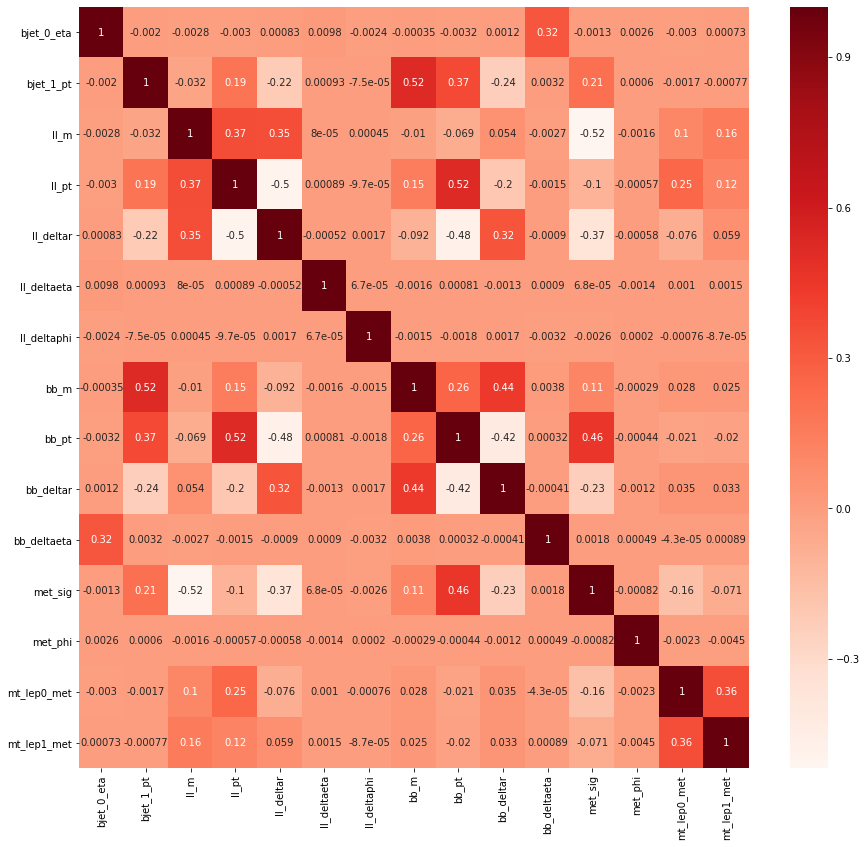

In [10]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/corr_sig.eps', format='eps', dpi=500)
plt.show()

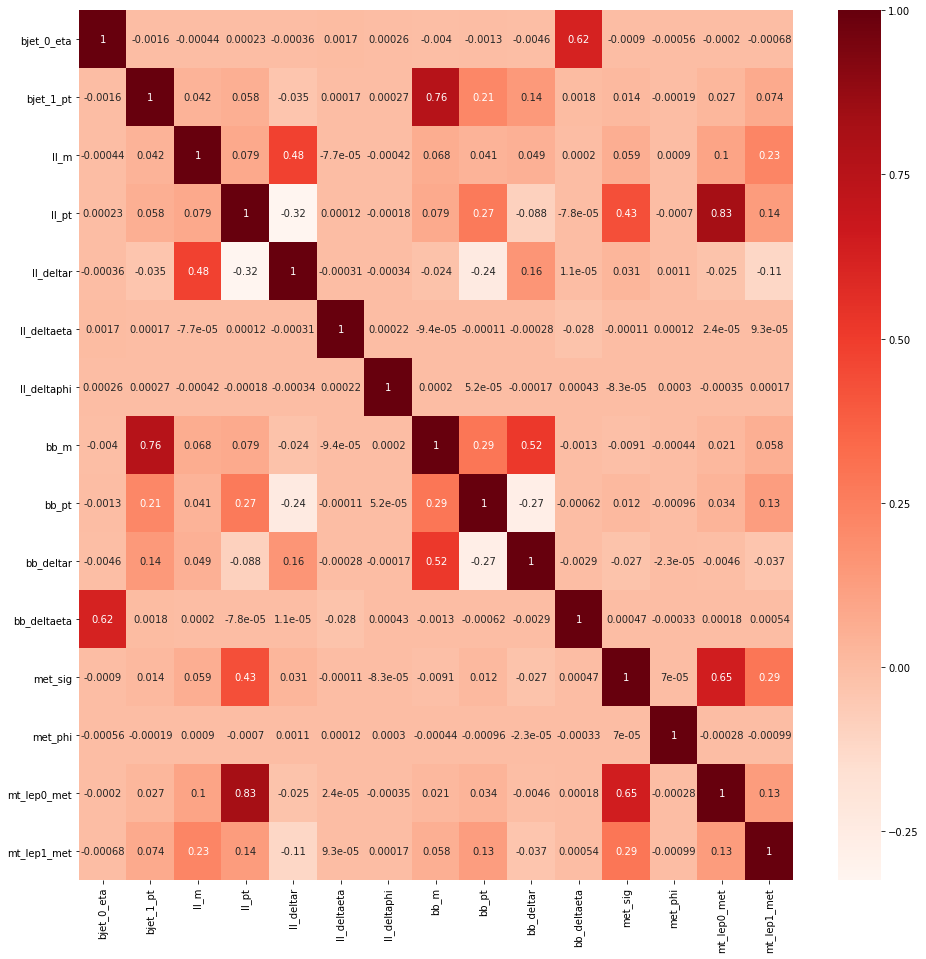

In [11]:
dataBackground=pd.DataFrame(data=backgroundArray[:,3:],columns=["bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
plt.figure(figsize=(16,16))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/corr_bkg.eps', format='eps', dpi=500)
plt.show()



In [12]:
print(signalArray)

[[ 2.01644220e-07  0.00000000e+00  0.00000000e+00 ...  4.87683773e-01
   8.13270781e+04  8.16832910e+03]
 [ 4.65245464e-05  0.00000000e+00  0.00000000e+00 ...  2.06075358e+00
   2.24752871e+04  4.82755898e+04]
 [ 4.08301212e-06  0.00000000e+00  1.00000000e+00 ... -6.78915754e-02
   2.70373242e+04  2.39445947e+03]
 ...
 [ 6.96462243e-07  1.00000000e+00  0.00000000e+00 ...  1.44230628e+00
   3.78105977e+04  4.17481328e+04]
 [ 8.11937758e-07  0.00000000e+00  1.00000000e+00 ...  2.93203044e+00
   4.69625273e+04  2.02780938e+04]
 [-3.84479825e-07  0.00000000e+00  1.00000000e+00 ... -2.78534222e+00
   3.25231875e+04  2.43024629e+04]]


In [13]:
print(signalArray[:,1])

[0. 0. 0. ... 1. 0. 0.]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [14]:
signalSample=signalArray[(abs(signalArray[:,5])>75000.0)&((signalArray[:,1]==1)|(signalArray[:,2]==1))]
backgroundSample=backgroundArray[(abs(backgroundArray[:,5])>75000.0)&((backgroundArray[:,1]==1)|(backgroundArray[:,2]==1))]

In [15]:
print(len(signalSample))
print(len(backgroundSample))

52680
11425015


In [16]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample[:,0]))
print("background yield after cut is:",sum(backgroundSample[:,0]))
SBratio=sum(signalSample[:,0])/sum(backgroundSample[:,0])
print("S/B ratio is: ",SBratio)
SigYield=sum(signalSample[:,0])
BkgYield=sum(backgroundSample[:,0])

signal event number after cut is:  52680
background event number after cut is: 11425015
signal yield after cut is:  0.4901765247906553
background yield after cut is: 960273.1071347836
S/B ratio is:  5.104553289565926e-07


Split datasets into training and testing subsets

In [17]:
trainingRatio=0.8
sigTrainNum=int(signalNum*0.8)
backgroundTrainNum=int(backgroundNum*0.8)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  42144
testing signal events number is:  10536
training background events number is:  9140012
testing background events number is:  2285003


In [18]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

[[ 0.00000000e+00 -1.81825807e-02  0.00000000e+00 ...  2.32160389e-01
   2.64334375e+05  1.93677719e+05]
 [ 0.00000000e+00  1.37044557e-02  1.00000000e+00 ... -2.20008779e+00
   3.38995625e+04  1.47853379e+04]
 [ 0.00000000e+00  3.00892636e-02  1.00000000e+00 ...  2.45293736e-01
   8.62061562e+04  4.53409688e+04]
 ...
 [ 0.00000000e+00  1.76521680e-02  0.00000000e+00 ... -2.84378338e+00
   2.94231582e+04  1.05910695e+05]
 [ 0.00000000e+00 -1.84298665e-02  1.00000000e+00 ... -5.67172408e-01
   1.10829156e+05  1.43861453e+05]
 [ 0.00000000e+00  1.92599260e-02  1.00000000e+00 ... -7.24466294e-02
   1.35716250e+05  1.15316586e+05]]
5.094462134353556e-07


In [19]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,4:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,4:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(9182156, 15) dtype=float32>

Signal and background training sets should have same yield in training

(9182156,)
(9182156,)


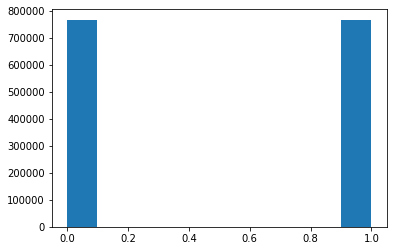

In [20]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

Build model

In [21]:
dataTrainSample1=min_max_renormal(dataTrainSample)

[[7.00127039e-01 8.08967037e-03 4.56585148e-03 ... 8.83099481e-01
  1.87688703e-04 3.69240674e-03]
 [1.86488281e-01 3.92580210e-03 3.07864675e-03 ... 4.85426704e-01
  6.22960207e-05 2.84407234e-03]
 [1.57318886e-01 2.42068620e-03 3.07154103e-03 ... 3.01766113e-01
  9.86260136e-05 1.15254167e-02]
 ...
 [9.66747275e-01 1.22338530e-02 1.09483364e-02 ... 4.43529452e-01
  9.91413996e-05 1.14268803e-02]
 [2.67844731e-01 4.46939080e-03 3.27867975e-03 ... 5.49585475e-01
  2.06369996e-04 2.12599312e-03]
 [2.23466780e-02 7.04492965e-03 1.94164659e-02 ... 9.00784170e-01
  1.74264127e-04 6.93981623e-04]]


In [ ]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     #optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
      optimizer='adam',
     metrics=["acc"])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [ ]:
model.save('model_HHZZ.h5')
model.summary()

In [ ]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

In [ ]:
signalSample1=min_max_renormal(signalSample[:,1:])
backgroundSample1=min_max_renormal(backgroundSample[:,1:])

In [ ]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

In [ ]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('model_HHZZ.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
         input_dim=21))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
    model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["accuracy"])
    return model

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=30, batch_size=50, verbose=False)
estimator.fit(dataTrainSample1,dataTrainLabel,sample_weight=dataTrainWeight)
perm = PermutationImportance(estimator, random_state=1).fit(dataTrainSample1,dataTrainLabel)

In [ ]:
eli5.show_weights(perm,feature_names=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

In [ ]:
cuda.select_device(0)
cuda.close()

In [187]:
varName=["bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalSample[:,3:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundSample[:,3:],feature_names=varName)
param = {'max_depth': 4, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
#param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


In [188]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist,early_stopping_rounds=5)

[0]	eval-auc:0.910132	train-auc:0.914558
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 5 rounds.
[1]	eval-auc:0.91809	train-auc:0.923047
[2]	eval-auc:0.926025	train-auc:0.931709
[3]	eval-auc:0.927894	train-auc:0.933616
[4]	eval-auc:0.929448	train-auc:0.93782
[5]	eval-auc:0.932843	train-auc:0.940735
[6]	eval-auc:0.933472	train-auc:0.945113
[7]	eval-auc:0.935027	train-auc:0.946673
[8]	eval-auc:0.936345	train-auc:0.948738
[9]	eval-auc:0.936687	train-auc:0.949257
[10]	eval-auc:0.938108	train-auc:0.949741
[11]	eval-auc:0.939454	train-auc:0.951447
[12]	eval-auc:0.940358	train-auc:0.952859
[13]	eval-auc:0.941762	train-auc:0.95428
[14]	eval-auc:0.942731	train-auc:0.955351
[15]	eval-auc:0.942662	train-auc:0.95666
[16]	eval-auc:0.943958	train-auc:0.958484
[17]	eval-auc:0.944742	train-auc:0.959482
[18]	eval-auc:0.944974	train-auc:0.960218
[19]	eval-auc:0.945328	train-auc:0.961035
[20]	eval-auc:0.945975	train-auc

In [164]:
GBDT=pickle.load(open("../BDT_model/GBDT_HH_region1.pickle.dat", "rb"))

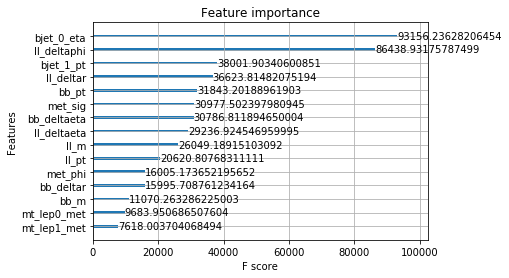

In [189]:
xgb.plot_importance(GBDT,importance_type="gain")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/ranking-region1-gain.pdf', format='pdf', dpi=500)

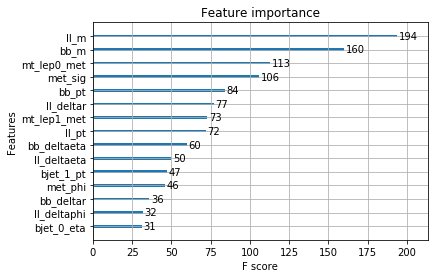

In [190]:
xgb.plot_importance(GBDT,importance_type="weight")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/ranking-region1-weight.pdf', format='pdf', dpi=500)

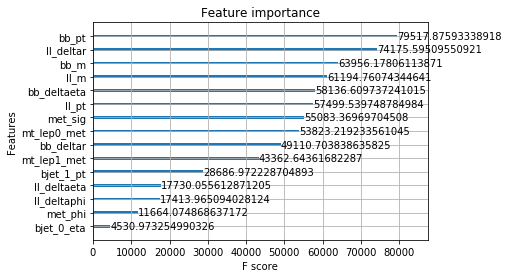

In [191]:
xgb.plot_importance(GBDT,importance_type="cover")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/ranking-region1-coverage.pdf', format='pdf', dpi=500)

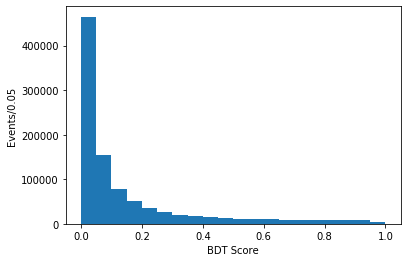

In [192]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/BDT-region1-bkg.pdf', format='pdf', dpi=500)
plt.show()

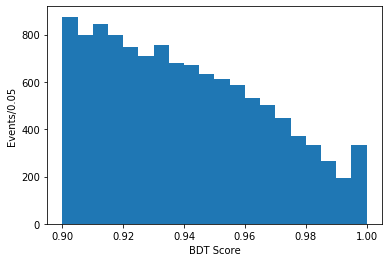

In [205]:
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,range=[0.9, 1.0],weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
plt.show()

In [ ]:
BDTBackground1=xgb.DMatrix(backgroundArray[:,3:],feature_names=varName)
BackgroundScore1=GBDT.predict(BDTBackground1)
plt.hist(BackgroundScore1,bins=10,range=[0.9,1.0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
plt.show()

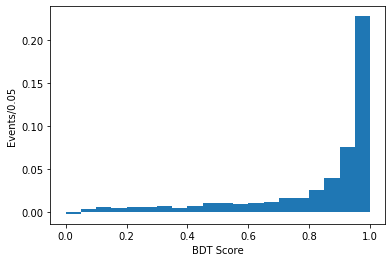

In [194]:
plt.hist(SignalScore,bins=20,weights=signalSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/BDT-region1-sig.pdf', format='pdf', dpi=500)
plt.show()

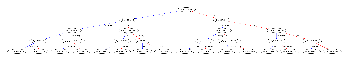

In [195]:
plot_tree(GBDT, num_trees=4)

(array([2611058., 1549889.,  986658.,  684782.,  509162.,  388552.,
         311496.,  254903.,  219802.,  195767.,  181489.,  170337.,
         156429.,  141079.,  131395.,  134061.,  143250.,  161929.,
         151445.,   98673.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

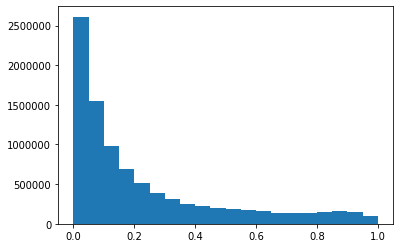

In [196]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [197]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

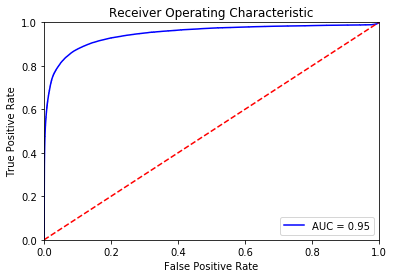

In [198]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/roc-region1-train.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [204]:
pickle.dump(GBDT, open("../BDT_model/GBDT_HH_region1.pickle.dat", "wb"))

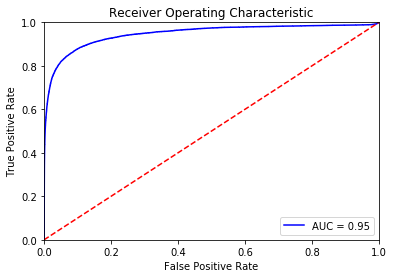

In [199]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0711/roc-region1-test.pdf', format='pdf', dpi=500)
plt.show()

In [200]:
drv.init()
mod=SourceModule("""
__global__ void func1(double *a, double *b, double *c,double thre, int N)
{ 
  extern __shared__ double sharedMem[256];
  double x=0;
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     if(a[i]>thre){
     sharedMem[threadIdx.x]+=b[i];
     }
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
func1=mod.get_function("func1") 

In [201]:
def cuda_sum(nump1,nump2,th):
    num1=np.float64(nump1.copy(order='C'))
    num2=np.float64(nump2.copy(order='C'))
    thres=np.float64(th)
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    N=np.int32(len(nump1))
    func1(drv.InOut(num1),drv.InOut(num2),drv.InOut(c1),thres,N,block=(nThreads, 1, 1),grid=(nBlocks,1))
    return(sum(c1))

In [202]:
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.9)
resS=cuda_sum(SignalScore,signalSample[:,0],0.9)
SBratio1=resS/resB
Sig1=resS/sqrt(resB)
print("If cut BDT at 0.9, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio1," Significance is: ",Sig1)
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.95)
resS=cuda_sum(SignalScore,signalSample[:,0],0.95)
SBratio2=resS/resB
Sig2=resS/sqrt(resB)
print("If cut BDT at 0.95, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio2," Significance is: ",Sig2)
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.975)
resS=cuda_sum(SignalScore,signalSample[:,0],0.975)
SBratio3=resS/resB
Sig3=resS/sqrt(resB)
print("If cut BDT at 0.975, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio3," Significance is: ",Sig3)

If cut BDT at 0.9, signal yield is: [0.30410935]  Eff is: [0.62040783]  background yield is: [11700.55695493]  Eff is:  [0.01218461]  S/B ratio is:  [2.59910151e-05]  Significance is:  [0.00281143]
If cut BDT at 0.95, signal yield is: [0.2283031]  Eff is: [0.46575689]  background yield is: [4181.58682896]  Eff is:  [0.00435458]  S/B ratio is:  [5.4597239e-05]  Significance is:  [0.00353054]
If cut BDT at 0.975, signal yield is: [0.15917634]  Eff is: [0.32473269]  background yield is: [1497.22204864]  Eff is:  [0.00155916]  S/B ratio is:  [0.00010631]  Significance is:  [0.00411373]


In [203]:
print("If cut at 0.9,   improvment is: ",SBratio1/SBratio)
print("If cut at 0.95,  improvment is: ",SBratio2/SBratio)
print("If cut at 0.975, improvment is: ",SBratio3/SBratio)

If cut at 0.9,   improvment is:  [50.91731563]
If cut at 0.95,  improvment is:  [106.95791748]
If cut at 0.975, improvment is:  [208.27376336]
